# Model hiper optimization

In [1]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [2]:
# configs.
%matplotlib inline

pd.set_option("display.max_columns", 500)

path = "../../data/split"
random_state = 42
print(os.listdir(path))

['1.1 - df_test 04-19to04-19.feather', '1.1 - df_train.feather', '1.1 - df_val 01-19to03-19.feather', '1.1 - df_test 04-19to05-19.feather', '1.1 - df_train only 2018 without nulls.feather', '1.1 - df_train with nan.feather']


## Loading training and validation datasets

In [11]:
df = pd.read_feather(os.path.join(path, "1.1 - df_train with nan.feather"))
df_val = pd.read_feather(os.path.join(path, "1.1 - df_val 01-19to03-19.feather"))

/home/voolkia/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [14]:
df["COD_ACT_BENEF"].get_dummies().head()

AttributeError: 'Series' object has no attribute 'get_dummies'

In [4]:
# dropping index variables
# to_drop = ["index"]
# df.drop(to_drop, axis=1, inplace=True)
# to_drop = ["level_0", "index"]
# df_val.drop(to_drop, axis=1, inplace=True)

In [5]:
# dropping NUM_SECU_EXPED
# to_drop = ["NUM_SECU_EXPED"]
# df.drop(to_drop, axis=1, inplace=True)
# df_val.drop(to_drop, axis=1, inplace=True)

In [6]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00'))

In [7]:
# using only last year
df_train = df[df["FECHA_SINI"] < "2018-10-01"].copy()
df_opt = df[df["FECHA_SINI"] >= "2018-10-01"].copy()
print(df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max())
print(df_opt["FECHA_SINI"].min(), df_opt["FECHA_SINI"].max())

2017-01-01 00:00:00 2018-09-30 00:00:00
2018-10-01 00:00:00 2018-12-31 00:00:00


In [8]:
# dropping date FEC_ACT_cond
to_drop = ["FECHA_SINI"]
df_train.drop(to_drop, axis=1, inplace=True)
df_opt.drop(to_drop, axis=1, inplace=True)
df_val.drop(to_drop, axis=1, inplace=True)

## split X, y dataset

In [9]:
df_train.groupby("COD_ACT_BENEF")["EXISTE_FRAUDE"].value_counts(dropna=False).unstack(fill_value=0)

EXISTE_FRAUDE,False,True
COD_ACT_BENEF,,
-1.0,490954,649
1.0,88202,43
2.0,2226,1
3.0,112091,3
4.0,14453,22
5.0,23,0
6.0,1397,2
7.0,34376,59
8.0,2077,13


In [10]:
# to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "EXISTE_INHABILITAR", "EXISTE_INVEST"]
to_drop = ["EXISTE_FRAUDE", "EXISTE_INHABILITAR", ]  # "COD_ACT_BENEF"

# training
X_train = df_train.drop(to_drop, axis=1)
y_train = df_train["EXISTE_FRAUDE"]
# validation
X_opt = df_opt.drop(to_drop, axis=1)
y_opt = df_opt["EXISTE_FRAUDE"]
# validation
X_val = df_val.drop(to_drop, axis=1)
y_val = df_val["EXISTE_FRAUDE"]

In [41]:
X_full_train = df.drop(to_drop, axis=1)
y_full_train = df["EXISTE_FRAUDE"]

In [42]:
# checking if all have the same inputs columns
print("dif between X_train & X_opt: {}".format(set(X_train.columns) - set(X_opt.columns)))
print("dif between X_val & X_opt: {}".format(set(X_val.columns) - set(X_opt.columns)))

dif between X_train & X_opt: set()
dif between X_val & X_opt: set()


In [43]:
print(f"{len(X_train)}, {len(X_opt)}")
print(f"{len(y_train)}, {len(y_opt)}")

845753, 120551
845753, 120551


In [44]:
y_train.sum() / len(y_train), y_opt.sum() / len(y_opt)

(0.0033532248777125235, 0.003973422037146104)

In [45]:
"EXISTE_INHABILITAR" in X_train.columns

False

## short optimization

In [46]:
from sklearn.ensemble import forest
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

#set_rf_samples(60000)

## Defining grid configuration

In [47]:
from sklearn.utils.class_weight import compute_class_weight

In [48]:
weights = compute_class_weight("balanced", df["EXISTE_FRAUDE"].unique(), df["EXISTE_FRAUDE"])
weights

array([  0.50162513, 154.33367436])

In [49]:
rf_params = {
#    "n_estimators": [40, 100],
#    "min_samples_leaf": [3, 7],
#    "max_depth": [3, 5, 10],
#    "max_features": ['sqrt', 0.5],
    "class_weight": [{0:1, 1:10}, {0:1, 1:18}, {0:1, 1:5}]
}

In [50]:
# using without grid
rf = RandomForestClassifier(n_estimators=40, max_features="sqrt",
                            min_samples_leaf=55, random_state=random_state, n_jobs=-1)
# rf.fit(X_full_train, y_full_train)

In [51]:
# TO avoid random sampling,
# WE USE GridSearch of hypopt 
clf = GridSearch(rf, param_grid=rf_params)
clf.fit(X_train, y_train, X_val=X_opt, y_val=y_opt, scoring="recall", verbose=True)

Comparing 3 parameter setting(s) using 8 CPU thread(s) ( 1 job(s) per thread ).


/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 18},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [52]:
print("Best Config:")
print(clf.best_params, clf.best_score)

Best Config:
{'class_weight': {0: 1, 1: 18}} 0.8308977035490606


In [53]:
print("Grid scores:")
for params, score in zip(clf.params, clf.scores):
    print("%0.3f for %r" % (score, params))

Grid scores:
0.831 for {'class_weight': {0: 1, 1: 18}}
0.808 for {'class_weight': {0: 1, 1: 10}}
0.752 for {'class_weight': {0: 1, 1: 5}}


In [54]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 18},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [55]:
y_val_pred = clf.best_estimator_.predict(X_val)
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.6031545741324921, 0.9391227671241025)

In [58]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[106157,    566],
       [    63,    478]])

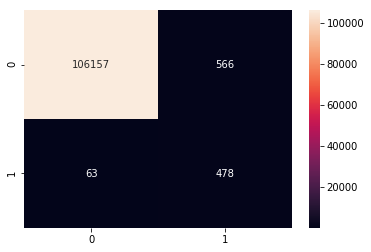

In [65]:
sns.heatmap(conf_mat, annot=True, fmt="")

## dumping best current config

In [208]:
# with open(ps.path.join("models", "s1 - cond_preg_fill-1_ class_weight balanced.pickle"), "wb") as file:
#     pickle.dump(rf_f, file)

## Feature Importance

<h3 style="color:red">When reducing the # of features the model get worst</h3>

In [24]:
rf_fi = pd.DataFrame({'cols':X_train.columns, 'fi':clf.best_estimator_.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
67,COD_ACT_BENEF,0.309857
91,TIPO_EXPED,0.082834
10,cond_C10,0.068411
44,preg_15,0.049822
11,cond_C11,0.043991
54,preg_32,0.028800
7,cond_32,0.026333
30,total_condicion,0.025970
12,cond_C12,0.020959
55,preg_33,0.019587


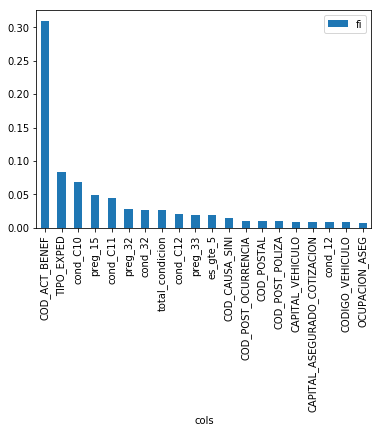

In [25]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [27]:
to_keep = list(rf_fi[rf_fi["fi"] >=0.005]["cols"].values)
print(f"# of features: {len(to_keep)} of {len(rf_fi)}")

# of features: 34 of 145


In [28]:
to_keep.remove("es_gte_5")
to_keep

['COD_ACT_BENEF',
 'TIPO_EXPED',
 'cond_C10',
 'preg_15',
 'cond_C11',
 'preg_32',
 'cond_32',
 'total_condicion',
 'cond_C12',
 'preg_33',
 'COD_CAUSA_SINI',
 'COD_POST_OCURRENCIA',
 'COD_POSTAL',
 'COD_POST_POLIZA',
 'CAPITAL_VEHICULO',
 'CAPITAL_ASEGURADO_COTIZACION',
 'cond_12',
 'CODIGO_VEHICULO',
 'OCUPACION_ASEG',
 'NUM_SECU_POL',
 'NUM_SECU_EXPED',
 'preg_31',
 'COD_PROD',
 'ANTIG_pol',
 'cond_37',
 'CANT_RENOVACION',
 'FECHA_SINI_Dayofyear',
 'cond_C5',
 'FECHA_SINI_Elapsed',
 'CODIGO_REAPERTURA',
 'dias_entre_denu_y_sini',
 'FECHA_SINI_Week',
 'FECHA_SINI_Day']

In [29]:
# best model
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 18},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [30]:
X_train_red = X_train[to_keep].copy()

NameError: name 'to_keep' is not defined

In [50]:
print(len(X_train_red.columns))

40


### Training again with less features

In [51]:
# rf = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=7, random_state=random_state, n_jobs=-1)
rf = copy(clf.best_estimator_)
rf.fit(X_train_red, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [52]:
y_val_pred = rf.predict(X_val[to_keep])
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.4741322855271774, 0.8316421631738862)

In [53]:
conf_mat =  confusion_matrix(y_val, y_val_pred)
conf_mat

array([[106099,    624],
       [   179,    362]])

In [ ]:
sns.heatmap(conf_mat, annot=True, fmt="d")

In [54]:
rf_fi = pd.DataFrame({'cols':X_train_red.columns, 'fi':rf.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
2,TIPO_EXPED,0.106869
0,cond_C10,0.100489
1,total_condicion,0.097119
3,preg_15,0.070213
4,cond_32,0.055359
8,cond_C12,0.047531
6,preg_33,0.034033
19,preg_32,0.030363
9,COD_POST_OCURRENCIA,0.026771
12,COD_POST_POLIZA,0.024260


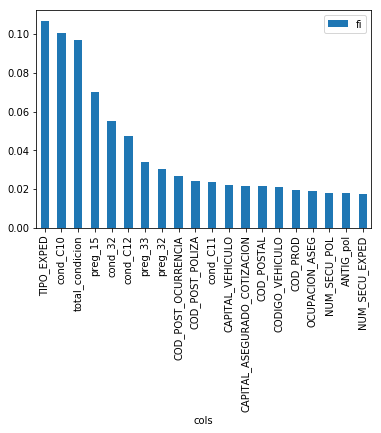

In [55]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [56]:
# best columns used
rf_fi["cols"].values

array(['TIPO_EXPED', 'cond_C10', 'total_condicion', 'preg_15', 'cond_32',
       'cond_C12', 'preg_33', 'preg_32', 'COD_POST_OCURRENCIA',
       'COD_POST_POLIZA', 'cond_C11', 'CAPITAL_VEHICULO',
       'CAPITAL_ASEGURADO_COTIZACION', 'COD_POSTAL', 'CODIGO_VEHICULO',
       'COD_PROD', 'OCUPACION_ASEG', 'NUM_SECU_POL', 'ANTIG_pol',
       'NUM_SECU_EXPED', 'FECHA_SINI_Elapsed', 'FECHA_SINI_Dayofyear',
       'CANT_RENOVACION', 'preg_34', 'TIPO_LESION', 'FECHA_SINI_Day',
       'FECHA_SINI_Week', 'preg_31', 'TIPO_SINIESTRO', 'SEGMENTO',
       'COD_CAUSA_SINI', 'dias_entre_denu_y_sini', 'cond_37',
       'COD_ZONA_ROBO', 'preg_28', 'FECHA_SINI_Dayofweek', 'FALTANTE',
       'COD_ZONA_RC', 'FECHA_SINI_Month', 'cond_C2'], dtype=object)

# final model

In [209]:
# reset_rf_samples()

## full features final model

In [159]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train, y_full_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [160]:
y_val_pred = rf_full.predict(X_val)
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val)[:, -1])
print("%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI))

0.554, 0.998


In [161]:
confusion_matrix(y_val, y_val_pred)

array([[105994,    747],
       [    37,    486]])

## red features final model

In [57]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train[to_keep], y_full_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=55,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [78]:
y_val_pred_prob = rf_full.predict_proba(X_val[to_keep])[:, -1]
y_val_pred = y_val_pred_prob > 0.32
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
print("%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI))

0.409, 0.980


In [79]:
confusion_matrix(y_val, y_val_pred)

array([[105750,    973],
       [   152,    389]])

## Tronador (sum cond >=5) comparison

In [28]:
# comparing against > 5 logic
y_tronador = X_val["total_condicion"] >= 5
print(f"({f1_score(y_val, y_tronador)},{roc_auc_score(y_val, y_tronador)})")

(0.3801229508196721,0.8380111222337413)


In [27]:
conf_mat = confusion_matrix(y_val, y_tronador)
conf_mat

NameError: name 'y_tronador' is not defined

In [ ]:
sns.heatmap(conf_mat, annot=True, fmt="d")

# Saving final model & columns used into hard drive

In [170]:
model_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - Model - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"

with open(model_file, "wb") as f:
    pickle.dump(rf_full, f, pickle.HIGHEST_PROTOCOL)

In [115]:
# save file for humans
# model_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - Model for humans - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"

# with open(model_file, "wb") as f:
#    pickle.dump(rf_full, f, 0) # 0 is human readable format

In [171]:
# merging list input & target
full_cols = list(to_keep) + ["EXISTE_FRAUDE"]
full_cols

['COD_RAMO',
 'COD_ACT_BENEF',
 'cond_C10',
 'es_gte_5',
 'total_condicion',
 'cond_C11',
 'preg_15',
 'cond_C12',
 'cond_32',
 'preg_31',
 'preg_32',
 'COD_CAUSA_SINI',
 'USR_ACT',
 'preg_34',
 'TIPO_EXPED',
 'preg_33',
 'SEGMENTO',
 'EXISTE_FRAUDE']

In [172]:
columns_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - COLUMNS - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"

with open(columns_file, "wb") as file:
    pickle.dump(full_cols, file, pickle.HIGHEST_PROTOCOL)

In [173]:
# saving for example a few rows to implement the model
df_example = X_val.loc[-100:, to_keep]
df_example["EXISTE_FRAUDE"] = y_val.loc[-100:]
df_example.to_feather("../../models/1.0 - df_train with nan 01-17to12-18/1.0 - dataset example to predict model.feather")

# reloading final model & columns and predict

In [174]:
model_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - Model - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"
with open(model_file, "rb") as file:
    m = pickle.load(file)

In [175]:
m

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [176]:
columns_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - COLUMNS - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"
with open(columns_file, "rb") as file:
    columns = pickle.load(file)

In [177]:
columns

['COD_RAMO',
 'COD_ACT_BENEF',
 'cond_C10',
 'es_gte_5',
 'total_condicion',
 'cond_C11',
 'preg_15',
 'cond_C12',
 'cond_32',
 'preg_31',
 'preg_32',
 'COD_CAUSA_SINI',
 'USR_ACT',
 'preg_34',
 'TIPO_EXPED',
 'preg_33',
 'SEGMENTO',
 'EXISTE_FRAUDE']

In [112]:
y_val_pred = m.predict(X_val[to_keep])
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, m.predict_proba(X_val[to_keep])[:, -1])
print("%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI))

0.696, 0.999


In [114]:
confusion_matrix(y_val, y_val_pred)

array([[106293,    448],
       [     5,    518]])

In [178]:
y_example_pred = m.predict_proba(df_example.drop(columns="EXISTE_FRAUDE"))[:, -1]
f1_score(y_val, y_val_pred > 0.5), roc_auc_score(y_val,y_example_pred)

(0.5274949083503055, 0.9987284136224165)

In [73]:
y_val.value_counts()

False    106741
True        523
Name: EXISTE_FRAUDE, dtype: int64